In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import copy

import npeet.entropy_estimators as ee
from uncertainty_forest.uncertainty_forest import UncertaintyForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal
from scipy.integrate import nquad

In [2]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
import mixed

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import tree

### Taken from Richard's "Reprod Figure 2"

In [4]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math

/home/ronak/miniconda3/envs/uf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
def cef_estimate(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        
        # RONAK EDIT STARTS HERE ################ In newer sklearn, generate unsampled takes a positional argument.
        #unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X), int((1 - max_samples)*len(X)))
        # RONAK EDIT ENDS HERE ##################
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

In [6]:
# def CART_estimate(X, y, n_trees = 300, bootstrap = True, depth = 30):
#     model = RandomForestClassifier(bootstrap = bootstrap, n_estimators =n_trees, max_depth = depth, max_features = math.ceil(int(math.sqrt(X.shape[1]))))
#     model.fit(X, y)
#     class_counts = np.zeros((X.shape[0], model.n_classes_))
#     for tree_in_forest in model:
#         # get number of training elements in each partition
#         node_counts = tree_in_forest.tree_.n_node_samples
#         # get counts for all x (x.length array)
#         partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
#         # get class probability for all x (x.length, n_classes)
#         class_probs = tree_in_forest.predict_proba(X)
#         # get elements by performing row wise multiplication
#         elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
#         # update counts for that tree
#         class_counts += elems
#     probs = class_counts/class_counts.sum(axis=1, keepdims=True)
#     entropies = -np.sum(np.log(probs)*probs, axis = 1)
#     # convert nan to 0
#     entropies = np.nan_to_num(entropies)
#     return np.mean(entropies)

### Generating data and prediction.

In [7]:
# def split_train_eval(X, y, frac_eval):
    
#     if frac_eval == 0:
#         return X, y, [], []
    
#     n = len(y)
#     n_eval = int(np.floor(frac_eval*n))
#     eval_indices = np.random.choice(np.arange(n), size = n_eval, replace = False)
#     X_eval = X[eval_indices, :]
#     y_eval = y[eval_indices]
#     X = np.delete(X, eval_indices, axis = 0)
#     y = np.delete(y, eval_indices, axis = 0)
    
#     return X, y, X_eval, y_eval

def generate_data(n, d, mu = 1, var1 = 1, pi = 0.5, truncate = False, three_class = False):
    
    means, Sigma, probs = _make_params(d, mu = mu, var1 = var1, pi = pi, three_class = three_class)
    counts = np.random.multinomial(n, probs, size = 1)[0]
    
    X_data = []
    y_data = []
    for k in range(len(probs)):
        X_data.append(np.random.multivariate_normal(means[k], Sigma, counts[k]))
        y_data.append(np.repeat(k, counts[k]))
    X = np.concatenate(tuple(X_data))
    y = np.concatenate(tuple(y_data))
    
    if truncate:
        for i in range(n):
            if X[i, 0] > 0:
                y[i] = 0
            elif X[i, 0] < 0:
                y[i] = 1
    
    return X, y

def _make_params(d, mu = 1, var1 = 1, pi = 0.5, three_class = False):
    
    if three_class:
        return _make_three_class_params(d, mu)
    
    mean = np.zeros(d)
    mean[0] = mu
    means = [mean, -mean]
    Sigma = np.eye(d)
    Sigma[0, 0] = var1
    probs = [pi, 1 - pi]
    
    return means, Sigma, probs

def _make_three_class_params(d, mu):
    
    means = []
    mean = np.zeros(d)
    
    mean[0] = mu
    means.append(copy.deepcopy(mean))
    
    mean[0] = -mu
    means.append(copy.deepcopy(mean))
    
    mean[0] = 0
    mean[d-1] = mu
    means.append(copy.deepcopy(mean))
    
    Sigma = np.eye(d)
    probs = [1/3.]*3
    
    return means, Sigma, probs

# def split_by_class(X, y):
    
#     classes, class_indices = np.unique(y, return_inverse = True)
#     K = len(classes)
#     X_by_class = []
#     y_by_class = []
    
#     for k in range(K):
#         class_ = classes[k]
#         X_k = X[y == class_,:]
#         y_k = np.repeat(class_, X_k.shape[0])
#         X_by_class.append(X_k)
#         y_by_class.append(y_k)
        
#     return X_by_class, y_by_class

## Plot the Setting ("Look at it!")

In [8]:
def plot_setting(n, setting, ax):
    
    mean = 3 if setting['name'] == 'Three Class Gaussians' else 1
    X, y = generate_data(n, 2, **setting['kwargs'], mu = mean)
        
    # X_by_class, y_by_class = split_by_class(X, y)
    colors = ["#c51b7d", "#2166ac", "#d95f02"]
    ax.scatter(X[:, 0], X[:, 1], color = np.array(colors)[y], marker = ".")
    
    # ax.set_ylim(bottom = -5.05)
    # ax.set_ylim(top = 5.05)
    ax.set_xlim(left = -5.05)
    ax.set_xlim(right = 5.05)
    
    ax.set_ylabel(setting['name'])

In [9]:
# Setting figures.
# colors = ["#d95f02", "#2166ac", "#c51b7d"]
settings = [
    {
        'name' : 'Sphereical Gaussians',
        'kwargs': {},
        # 'colors' : colors[1:3],
        'filename' : 'spherical'
    },
    {
        'name' : 'Elliptical Gaussians',
        'kwargs': {'var1' : 3},
        # 'colors' : colors[1:3],
        'filename' : 'ellyptical'
    },
#     {
#         'name' : 'Imbalanced Classes',
#         'kwargs': {'pi' : 0.8},
#         # 'colors' : colors[1:3],
#         'filename' : 'imbalanced'
#     },
#     {
#         'name' : 'Truncated Gaussians',
#         'kwargs': {'truncate' : True},
#         # 'colors' : colors[1:3],
#         'filename' : 'truncated'
#     },
    {
        'name' : 'Three Class Gaussians',
        'kwargs': {'three_class' : True},
        # 'colors' : colors,
        'filename' : 'three_class'
    },
]

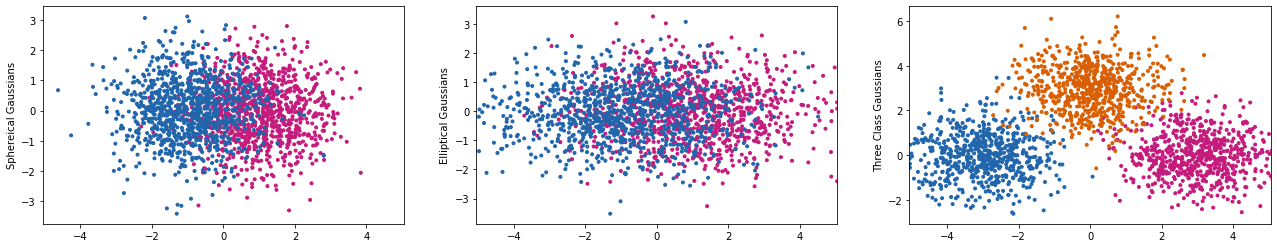

<Figure size 432x288 with 0 Axes>

In [10]:
# Plot data.
fig, axes = plt.subplots(1, len(settings), figsize = (22,4))
for i, setting in enumerate(settings):
    plot_setting(2000, setting, axes[i])
    
plt.show()
plt.clf()

In [11]:
# def estimate_mi(X, y, label, obj, frac_eval, base = 2):
#     if label == 'UF':
#         X, y, X_eval, y_eval = split_train_eval(X, y, frac_eval)
#         obj.fit(X, y)
#         return obj.estimate_mutual_info(X_eval)
#     elif label == 'KSG':
#         return ee.mi(X, np.array(y).reshape(-1, 1))
#     elif label == 'Mixed KSG':
#         return mixed.Mixed_KSG(X, y.reshape(-1, 1))
#     elif label == 'IRF':
#         X, y, X_eval, y_eval = split_train_eval(X, y, frac_eval)
#         obj.fit(X, y)
        
#         _, counts = np.unique(y, return_counts=True)
#         H_Y = entropy(counts, base=base)
        
#         p = obj.predict_proba(X_eval)
#         H_YX = np.mean(entropy(p.T, base=base))
#         return H_Y - H_YX
#     else:
#         raise ValueError("Uncrecognized label!")

## Effect Size Plots

In [12]:
def compute_mutual_info(d, base = np.exp(1), mu = 1, var1 = 1, pi = 0.5, three_class = False, truncate = False):
    
    if d > 1:
        dim = 2
    else:
        dim = d
 
    means, Sigma, probs = _make_params(dim, mu = mu, var1 = var1, pi = pi, three_class = three_class)
    
    # Compute entropy and X and Y.
    def func(*args):
        x = np.array(args)
        p = 0
        for k in range(len(means)):
            p += probs[k] * multivariate_normal.pdf(x, means[k], Sigma)
        return -p * np.log(p) / np.log(base)

    scale = 10
    lims = [[-scale, scale]]*dim
    H_X, int_err = nquad(func, lims)
    H_Y = entropy(probs, base = base)
    
    if truncate:
        return H_Y, H_X, H_Y
    
    # Compute MI.
    H_XY = (dim * np.log(2*np.pi) + np.log(np.linalg.det(Sigma)) + dim) / (2 * np.log(base))
    I_XY = H_X - H_XY
    
    return I_XY, H_X, H_Y

In [13]:
def get_mutual_info_vs_mu(n, d, num_trials, mus, setting, frac_eval, base = np.exp(1)):
    
    # uf = np.zeros((len(mus), num_trials))
    # cart = np.zeros((len(mus), num_trials))
    # irf = np.zeros((len(mus), num_trials))
    ksg = np.zeros((len(mus), num_trials))
    # mksg = np.zeros((len(mus), num_trials))
    
    def worker(t):
        X, y = generate_data(n, d, mu = elem, **setting['kwargs'])
        I_XY, H_X, H_Y = compute_mutual_info(d, mu = elem, **setting['kwargs'])
        norm_factor = min(H_X, H_Y)
        
        # UF
#         _, counts = np.unique(y, return_counts=True)
#         est_H_Y = entropy(counts, base=np.exp(1))
#         uf_out = (est_H_Y - cef_estimate(np.array(X), y, 300, .32, depth = 30)) / norm_factor
        
        # CART
        # cart_out = CART_estimate(X, y)
        
        # IRF
#         irf_obj = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
#                                      method='isotonic', 
#                                      cv = 5)
#         X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size = frac_eval)
#         irf_obj.fit(X_train, y_train)
#         p = irf_obj.predict_proba(X_eval)
#         irf_out = (est_H_Y - np.mean(entropy(p.T, base = base))) / norm_factor
        
        # KSG
        # ksg_out = ee.mi(X, np.array(y).reshape(-1, 1)) / norm_factor
        ksg_out = mixed.KSG(X, y.reshape(-1, 1)) / norm_factor
        
        # MKSG
        # mksg_out = mixed.Mixed_KSG(X, y.reshape(-1, 1)) / norm_factor
        
        # return (uf_out, irf_out, ksg_out, mksg_out)
        return (0, 0, ksg_out, 0)
    
    for i, elem in enumerate(mus):
        output = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        # uf[i, :] = output[:, 0]
        # cart[i, :] = output[:, 1]
        # irf[i, :] = output[:, 1]
        ksg[i, :] = output[:, 2]
        # mksg[i, :] = output[:, 3]
        
    # pickle.dump(mus, open('mus.pkl', 'wb'))
    # pickle.dump(uf, open('uf_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'wb'))
    # pickle.dump(cart, open('cart_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'wb'))
    # pickle.dump(irf, open('irf_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'wb'))
    pickle.dump(ksg, open('ksg_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'wb'))
    # pickle.dump(mksg, open('mksg_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'wb'))

    # return uf, irf, ksg, mksg
    return 0

In [14]:
# def mutual_info_distribution(n, d, frac_eval, algos, num_trials, setting, mu, base = 2, parallel = False):
    
#     # Compute normalizing factors.
#     kwargs = copy.deepcopy(setting['kwargs'])
#     kwargs['mu'] = mu
#     _, H_X, H_Y = compute_norm_mutual_info(base = base, **kwargs)
#     factor = min(H_X, H_Y)
    
#     # For each trial, generate data and compute conditional entropy for each algorithm.
#     def worker(t):
#         X, y = generate_data(n, d, **kwargs)
#         X, y, X_eval, _ = split_train_eval(X, y, frac_eval)
        
#         ret = np.zeros(len(algos))
#         for j in range(len(algos)):
#             # Estimate conditional probability of Y | X.
#             ret[j] = estimate_mi(X, y, algos[j]['label'], algos[j]['instance'], frac_eval) / factor
#         return ret
    
#     if parallel:
#         predicted_mutual_info = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
#     else:
#         predicted_mutual_info = np.zeros((num_trials, len(algos)))
#         for t in tqdm(range(num_trials)):
#             predicted_mutual_info[t, :] = worker(t)
            
#     return predicted_mutual_info

In [15]:
# def mutual_info_by_mu(mus, n, d, frac_eval, algos, num_trials, setting, parallel = False):
#     # Repeat for all 'mu', and save output in the 'algos' array.
#     mutual_info_range = np.zeros((len(mus), num_trials, len(algos)))
#     for i in range(len(mus)):
#         mutual_info_range[i, :, :] = mutual_info_distribution(n, 
#                                                               d, 
#                                                               frac_eval, 
#                                                               algos, 
#                                                               num_trials,
#                                                               setting,
#                                                               mus[i], 
#                                                               parallel = parallel)      
#     for j in range(len(algos)):
#         algos[j]['mi_by_mu_d_%d_%s' % (d, setting['filename'])] = mutual_info_range[:, :, j]
        
#     with open('algos_fig3.pkl', 'wb') as f:
#         pickle.dump(algos, f)
#     with open('mus_fig3.pkl', 'wb') as f:
#         pickle.dump(mus, f)

In [16]:
def plot_mutual_info_by_mu(setting, algos, d, ax):
    
    mus = pickle.load(open('mus.pkl', 'rb'))
    uf = pickle.load(open('uf_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'rb'))
    # cart = pickle.load(open('cart_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'rb'))
    irf = pickle.load(open('irf_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'rb'))
    ksg = pickle.load(open('ksg_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'rb'))
    mksg = pickle.load(open('mksg_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'rb'))
    results = [irf, ksg, mksg, uf]
    
    for j, algo in enumerate(algos):
        # Plot the mean over trials as a solid line.
        ax.plot(mus, 
                np.mean(results[j], axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 3 if algo['label'] == 'Mixed KSG' else 2, 
                color = algo['color'])
    
#     truth = np.zeros(len(mus))
#     for i in range(len(mus)):
#         I_XY, H_X, H_Y = compute_mutual_info(d, **setting['kwargs'], mu = mus[i])
#         truth[i] = I_XY / min(H_X, H_Y)
    truth = pickle.load(open('truth_d_%d_%s.pkl' % (d, setting['filename']), 'rb'))
    ax.plot(mus, truth, label = 'Truth', linewidth = 2, color = 'black')

    ax.set_xlabel("Effect Size")
    ax.set_ylabel("Estimated Normalized MI")
    
    ax.set_ylim(bottom = -0.05)
    ax.set_ylim(top = 1.05)
    ax.set_xlim(left = np.amin(mus) - 0.05)
    ax.set_xlim(right = np.amax(mus) + 0.05)

In [17]:
# Data.
n = 10000
mus = range(5)
num_trials = 20
frac_eval = 0.3
# n_estimators = 500
d1 = 1
d2 = 40

# Algorithms.
algos = [
    {
#         'instance': CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = n_estimators), 
#                                            method='isotonic', 
#                                            cv = 5),
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
#         'instance': None,
        'label': 'KSG',
        'title': 'KSG',
        'color': "#1b9e77",
    },
    {
#         'instance': None,
        'label': 'Mixed KSG',
        'title': 'Mixed KSG',
        'color': "purple",
    },
    {
#         'instance': UncertaintyForest(n_estimators = n_estimators),
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

In [18]:
# for setting in settings:
#     mutual_info_by_mu(mus, n, d1, frac_eval, algos, num_trials, setting, parallel = parallel)
#     mutual_info_by_mu(mus, n, d2, frac_eval, algos, num_trials, setting, parallel = parallel)

In [19]:
for setting in settings:
    get_mutual_info_vs_mu(n, d1, num_trials, mus, setting, frac_eval)
    get_mutual_info_vs_mu(n, d2, num_trials, mus, setting, frac_eval)

In [20]:
# Compute true values for normalized mutual info.
def compute_truth(d, setting, mus):
    truth = np.zeros(len(mus))
    for i in range(len(mus)):
        I_XY, H_X, H_Y = compute_mutual_info(d, **setting['kwargs'], mu = mus[i])
        truth[i] = I_XY / min(H_X, H_Y)
        
    pickle.dump(truth, open('truth_d_%d_%s.pkl' % (d, setting['filename']), 'wb'))

In [21]:
for setting in settings:
    compute_truth(d1, setting, mus)
    compute_truth(d2, setting, mus)

In [22]:
def plot_fig3(algos, d1, d2, settings):
    sns.set(font_scale = 1.5)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    fig, axes = plt.subplots(len(settings), 3, figsize = (15,13))
    
#     with open('truth_fig3_d_%d.pkl' % d1, 'rb') as f:
#         truth_1 = pickle.load(f)
#     with open('truth_fig3_d_%d.pkl' % d2, 'rb') as f:
#         truth_2 = pickle.load(f)

    for s, setting in enumerate(settings):
        plot_setting(2000, setting, axes[s, 0])
        plot_mutual_info_by_mu(setting, algos, d1, axes[s, 1])
        plot_mutual_info_by_mu(setting, algos, d2, axes[s, 2])
        
    axes[0, 1].set_title('d = %d' % d1)
    axes[0, 2].set_title('d = %d' % d2)
    axes[0, 2].legend(loc = "upper right")

    plt.yticks(fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.tight_layout()
    plt.savefig("fig3.pdf")
    plt.show()

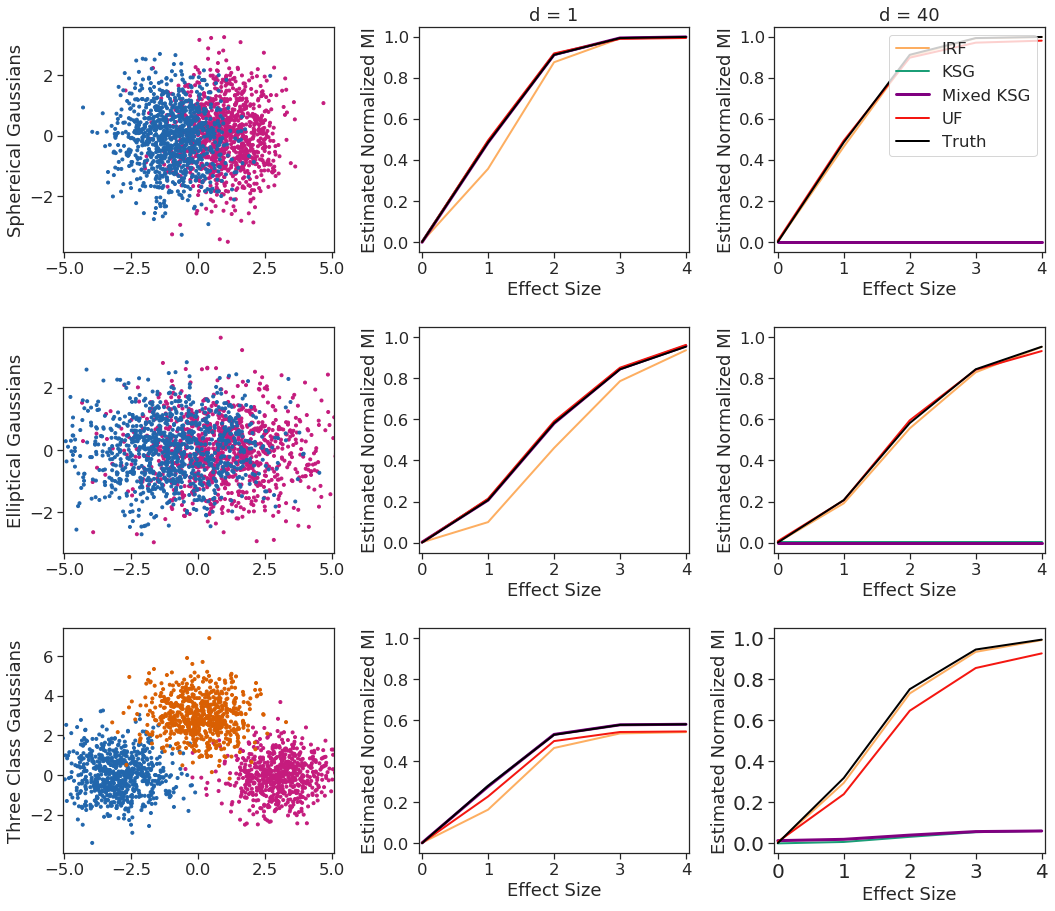

In [23]:
# Run settings cell first.
plot_fig3(algos, d1, d2, settings)

In [24]:
# Inspect Mixed KSG output.
# setting = settings[0] # Spherical
# d = 1

# truth = pickle.load(open('truth_d_%d_%s.pkl' % (d, setting['filename']), 'rb'))

# mksg = pickle.load(open('mksg_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'rb'))
# print(np.mean(mksg, axis = 1).flatten())
# print(truth)

# Inspect Truncated output.
setting = settings[2] # Truncated
d = 1

truth = pickle.load(open('truth_d_%d_%s.pkl' % (d, setting['filename']), 'rb'))
mksg = pickle.load(open('mksg_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'rb'))
ksg = pickle.load(open('ksg_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'rb'))

print(np.mean(mksg, axis = 1).flatten())
print(np.mean(ksg, axis = 1).flatten())
print(truth)

[0.0009248  0.27563528 0.5296823  0.57648797 0.57926751]
[-0.00128504  0.2800643   0.52990638  0.57699225  0.5782136 ]
[2.02113709e-16 2.78357532e-01 5.27942092e-01 5.76092329e-01
 5.79300117e-01]


In [25]:
# Correct KSG normalized output.
# It is divided by norm_factor when computed, but it is possible that they're output is already normalized.
# for d in [d1, d2]:
#     for setting in settings:
#         ksg = pickle.load(open('ksg_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'rb'))
#         for i in range(len(mus)):
#             I_XY, H_X, H_Y = compute_mutual_info(d, **setting['kwargs'], mu = mus[i])
#             norm_factor = min(H_X, H_Y)
#             ksg[i] *= norm_factor
#         pickle.dump(ksg, open('ksg_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'wb'))

In [1]:
# def get_mutual_info_vs_mu(n, d, num_trials, mus, setting, frac_eval, base = np.exp(1)):
    
#     # uf = np.zeros((len(mus), num_trials))
#     # cart = np.zeros((len(mus), num_trials))
#     # irf = np.zeros((len(mus), num_trials))
#     ksg = np.zeros((len(mus), num_trials))
#     # mksg = np.zeros((len(mus), num_trials))
    
#     def worker(t):
#         X, y = generate_data(n, d, mu = elem, **setting['kwargs'])
#         I_XY, H_X, H_Y = compute_mutual_info(d, mu = elem, **setting['kwargs'])
#         norm_factor = min(H_X, H_Y)
        
#         # UF
# #         _, counts = np.unique(y, return_counts=True)
# #         est_H_Y = entropy(counts, base=np.exp(1))
# #         uf_out = (est_H_Y - cef_estimate(np.array(X), y, 300, .32, depth = 30)) / norm_factor
        
#         # CART
#         # cart_out = CART_estimate(X, y)
        
#         # IRF
# #         irf_obj = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
# #                                      method='isotonic', 
# #                                      cv = 5)
# #         X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size = frac_eval)
# #         irf_obj.fit(X_train, y_train)
# #         p = irf_obj.predict_proba(X_eval)
# #         irf_out = (est_H_Y - np.mean(entropy(p.T, base = base))) / norm_factor
        
#         # KSG
#         ksg_out = mixed.KSG(X, y.reshape(-1, 1)) / norm_factor
        
#         # MKSG
#         # mksg_out = mixed.Mixed_KSG(X, y.reshape(-1, 1)) / norm_factor
        
#         # return (uf_out, irf_out, ksg_out, mksg_out)
#         return (0, 0, ksg_out, 0)
    
#     for i, elem in enumerate(mus):
#         output = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
#         # uf[i, :] = output[:, 0]
#         # cart[i, :] = output[:, 1]
#         # irf[i, :] = output[:, 1]
#         ksg[i, :] = output[:, 2]
#         # mksg[i, :] = output[:, 3]
        
#     # pickle.dump(mus, open('mus.pkl', 'wb'))
#     # pickle.dump(uf, open('uf_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'wb'))
#     # pickle.dump(cart, open('cart_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'wb'))
#     # pickle.dump(irf, open('irf_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'wb'))
#     pickle.dump(ksg, open('ksg_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'wb'))
#     # pickle.dump(mksg, open('mksg_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'wb'))

#     # return uf, irf, ksg, mksg
#     return 0

In [ ]:
#     mus = pickle.load(open('mus.pkl', 'rb'))
#     uf = pickle.load(open('uf_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'rb'))
#     # cart = pickle.load(open('cart_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'rb'))
#     irf = pickle.load(open('irf_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'rb'))
#     ksg = pickle.load(open('ksg_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'rb'))
#     mksg = pickle.load(open('mksg_by_mu_d_%d_%s.pkl' % (d, setting['filename']), 'rb'))
#     results = [irf, ksg, mksg, uf]
    
#     for j, algo in enumerate(algos):
#         # Plot the mean over trials as a solid line.
#         ax.plot(mus, 
#                 np.mean(results[j], axis = 1).flatten(), 
#                 label = algo['label'], 
#                 linewidth = 3 if algo['label'] == 'Mixed KSG' else 2, 
#                 color = algo['color'])
    
# #     truth = np.zeros(len(mus))
# #     for i in range(len(mus)):
# #         I_XY, H_X, H_Y = compute_mutual_info(d, **setting['kwargs'], mu = mus[i])
# #         truth[i] = I_XY / min(H_X, H_Y)
#     truth = pickle.load(open('truth_d_%d_%s.pkl' % (d, setting['filename']), 'rb'))
#     ax.plot(mus, truth, label = 'Truth', linewidth = 2, color = 'black')

#     ax.set_xlabel("Effect Size")
#     ax.set_ylabel("Estimated Normalized MI")
    
#     ax.set_ylim(bottom = -0.05)
#     ax.set_ylim(top = 1.05)
#     ax.set_xlim(left = np.amin(mus) - 0.05)
#     ax.set_xlim(right = np.amax(mus) + 0.05)
    
    # ---------------------------------------